In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import math
import itertools
import datetime
#from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib

# Read endogenous and exogenous data and filter country/dates

In [2]:
# We read the endogenous data (coronavirus data)

covid_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid = pd.read_csv(covid_url, parse_dates=['date'], index_col=['date'])

In [3]:
# We filter the country, dates and the variable to predict

country = 'Spain'
variable = 'new_cases'
initialdate = '01-01-2020'
enddate = '30-06-2020' 

# Filtering country and dates
covid_ctry = covid[covid['location']==country]
covid_ctry = covid_ctry.loc[initialdate:enddate]

# Making the data a daily series and applying 7-day rolling mean
covid_ctry_var = covid_ctry[variable]
#covid_ctry_var = covid_ctry_var.resample('D').sum()
covid_ctry_varR = covid_ctry_var.rolling(7).mean().dropna()

In [4]:
# We now read the exogenous data (for now, from a local file)

exogenous = pd.read_csv('./data/exogenas.csv', parse_dates=[0], index_col=[0])

In [5]:
# We now need to filter the country/dates, and aply 7-day rolling mean:

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]
exogenous_ctry = exogenous_ctry.loc[initialdate:enddate]

# We apply the 7-day rolling mean, as in the endogenous data
exogenous_ctryR = exogenous_ctry.rolling(7).mean().dropna()

In [6]:
# We check that the only NaNs removed are the 6 positions created by the 7-rolling mean
print(len(covid_ctry_varR) == len(covid_ctry_var) - 6)
print(len(exogenous_ctryR) == len(exogenous_ctry) - 6)

True
True


# Visualize endogenous and exogenous data and normalize it all

(176,) (176, 13)


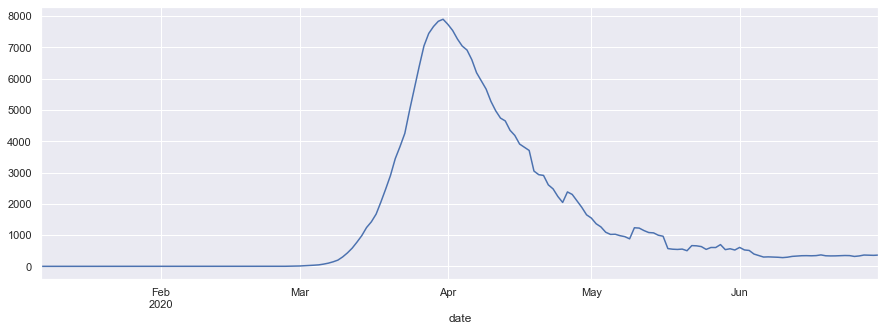

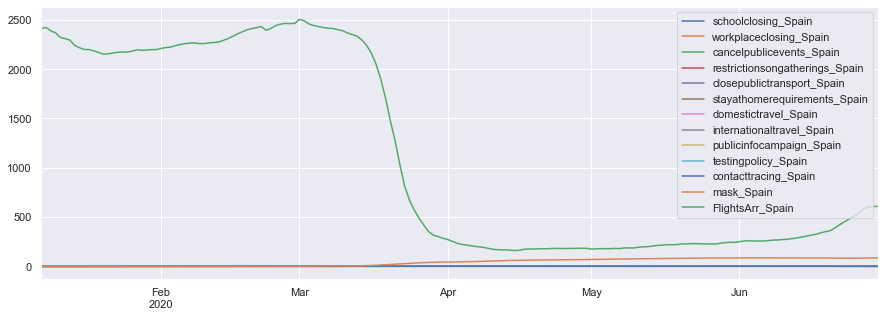

In [7]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [8]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [19]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR.values.reshape(-1,1))
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.name)
y = scaled_output.resample('1D').sum()

(176,) (176, 13)


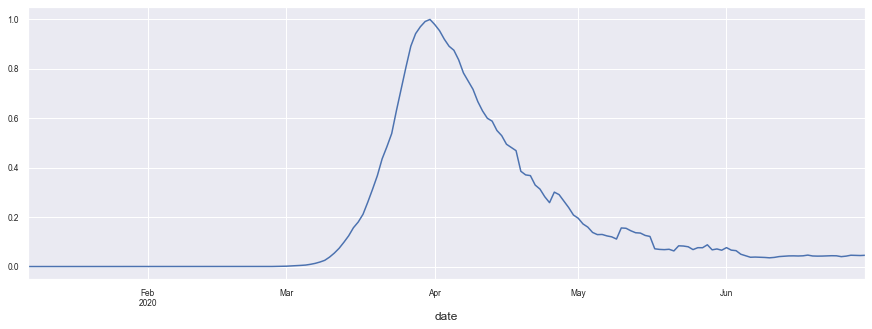

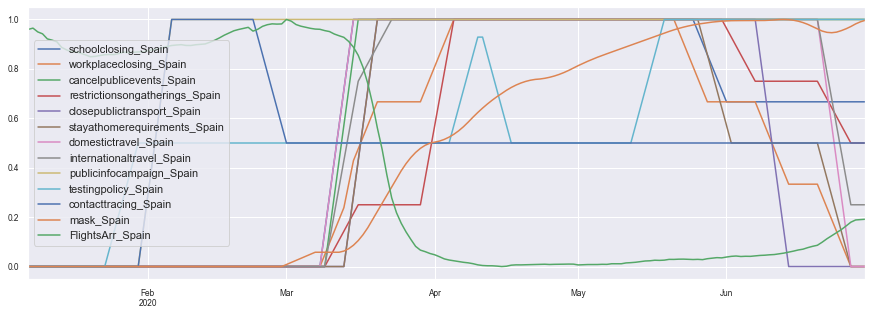

In [20]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [21]:
# We are going to use 90% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.90)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [22]:
train_size, test_size

(158, 18)

# Stationarity: estimate differencing term (d)

In [23]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


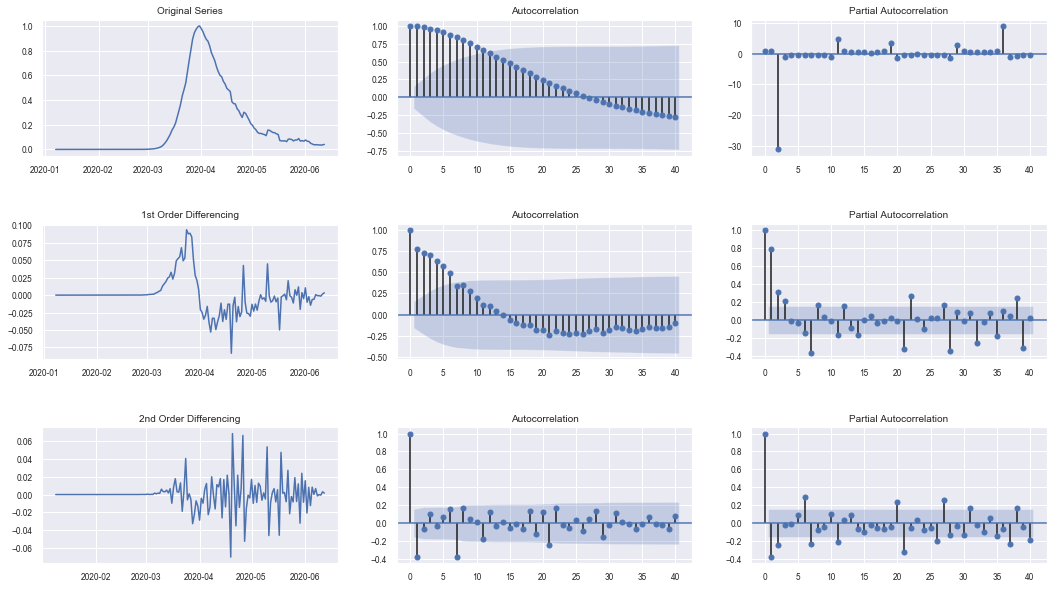

In [24]:
# Plotting ACF and PACF with the different 'd' values from previous step

plt.rcParams.update({'figure.figsize':(18,10), 'figure.subplot.hspace':0.5,
                     'xtick.labelsize':'x-small', 'ytick.labelsize':'x-small', 'axes.titlesize':'small'})
fig, axes = plt.subplots(3, 3)

# Original Series
axes[0, 0].plot(y_train); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(y_train, lags=40, ax=axes[0, 1])
sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(y_train.diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().dropna(), lags=40, ax=axes[1, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().dropna(), lags=40, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 2])
plt.show()
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

In [25]:
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

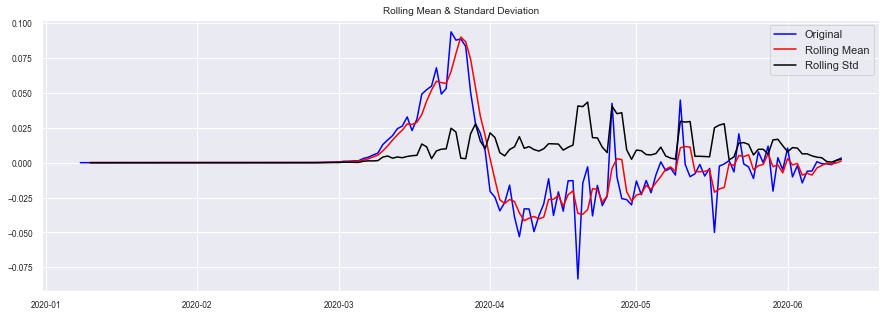

Result of Dicky=Fuller Test
Test Statistic           -2.893165
p-value                   0.046149
#Lags Used                7.000000
#Observations Used      149.000000
Critical Value (1%)      -3.475018
Critical Value (5%)      -2.881141
Critical Value (10%)     -2.577221
dtype: float64


In [26]:
test_stationarity(y_train.diff().dropna())

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

# Estimate order p and q of ARIMA model, using auto_arima

Fit ARIMA(0,2,0)x(0,0,0,1) [intercept=True]; AIC=-817.481, BIC=-771.733, Time=0.192 seconds
Fit ARIMA(0,2,1)x(0,0,0,1) [intercept=True]; AIC=-855.132, BIC=-806.334, Time=0.590 seconds
Fit ARIMA(0,2,2)x(0,0,0,1) [intercept=True]; AIC=-853.854, BIC=-802.007, Time=0.678 seconds
Fit ARIMA(0,2,3)x(0,0,0,1) [intercept=True]; AIC=-859.770, BIC=-804.872, Time=0.682 seconds
Fit ARIMA(0,2,4)x(0,0,0,1) [intercept=True]; AIC=-859.905, BIC=-801.958, Time=0.746 seconds
Fit ARIMA(0,2,5)x(0,0,0,1) [intercept=True]; AIC=-855.674, BIC=-794.677, Time=0.756 seconds
Fit ARIMA(1,2,0)x(0,0,0,1) [intercept=True]; AIC=-843.241, BIC=-794.444, Time=0.546 seconds
Fit ARIMA(1,2,1)x(0,0,0,1) [intercept=True]; AIC=-852.955, BIC=-801.107, Time=0.576 seconds
Fit ARIMA(1,2,2)x(0,0,0,1) [intercept=True]; AIC=-851.909, BIC=-797.011, Time=0.627 seconds
Fit ARIMA(1,2,3)x(0,0,0,1) [intercept=True]; AIC=-855.484, BIC=-797.537, Time=0.724 seconds
Fit ARIMA(1,2,4)x(0,0,0,1) [intercept=True]; AIC=-856.917, BIC=-795.920, Time=0.

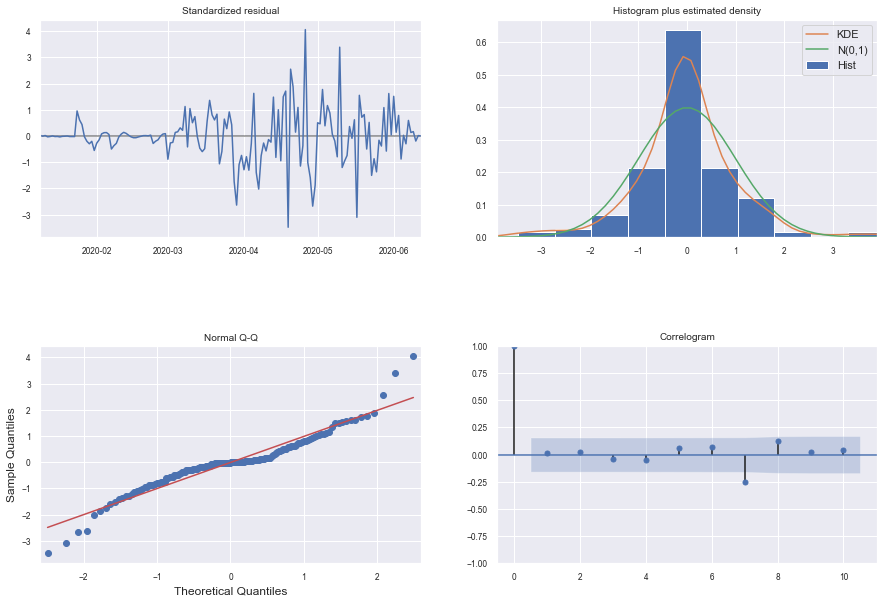

In [18]:
modelauto7 = pm.auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                    #  test='adf',       # use kpss to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(modelauto7.summary())
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

# Train and fit SARIMAX model with previous selected (p,d,q) orders

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:              new_cases   No. Observations:                  158
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 441.660
Date:                Tue, 11 Aug 2020   AIC                           -847.320
Time:                        13:48:15   BIC                           -792.308
Sample:                    01-07-2020   HQIC                          -824.978
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain               -0.2392      0.684     -0.350      0.727      -1.580       1.102
workplaceclosing_Spain            -0.2254      0.207     -1.087      0.

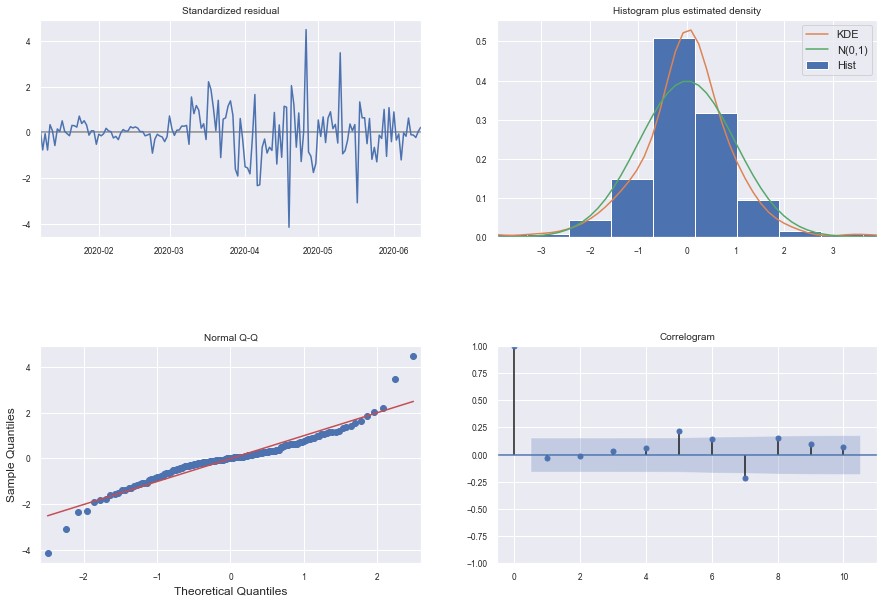

In [27]:
model1 = sm.tsa.statespace.SARIMAX(y_train, order=(4,1,0), exog=X_train)
results1 = model1.fit()
print(results1.summary())
results1.plot_diagnostics(figsize=(15,10));

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:              new_cases   No. Observations:                  158
Model:               SARIMAX(0, 2, 4)   Log Likelihood                 449.560
Date:                Tue, 11 Aug 2020   AIC                           -863.120
Time:                        13:48:44   BIC                           -808.223
Sample:                    01-07-2020   HQIC                          -840.823
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain               -0.3242      0.644     -0.503      0.615      -1.586       0.938
workplaceclosing_Spain            -0.1915      0.188     -1.021      0.

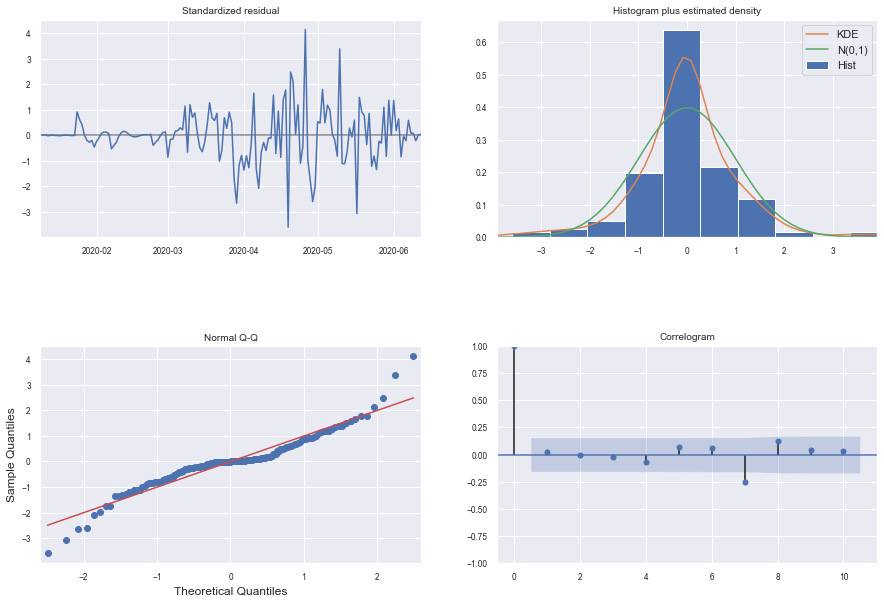

In [29]:
model2 = sm.tsa.statespace.SARIMAX(y_train, order=(0,2,4), exog=X_train)
results2 = model2.fit()
print(results2.summary())
results2.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast (static or dynamic?) and evaluate model RMSE

In [30]:
train_size, test_size, X_test.shape

(158, 18, (18, 13))

In [32]:
X.index

DatetimeIndex(['2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', length=176, freq=None)

In [34]:
# Generate in-sample predictions (train)

in_predictions = results2.predict(exog=X_train)

#act = pd.DataFrame(scaled_output[train_size:])
#plt.plot(y_train.index, y_train)
#plt.plot(in_predictions.index, in_predictions, color='blue', label='predictions')
#plt.plot(act.index, act, color='red', label='actual')
#plt.legend()
#plt.show()

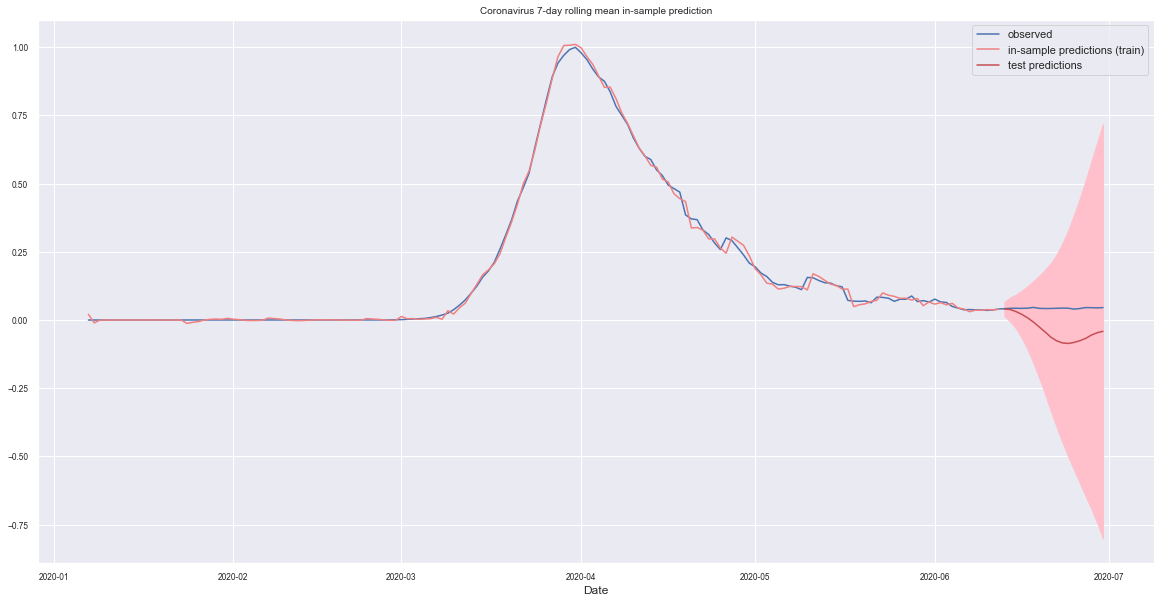

In [45]:
# Generate predictions for the test sample
one_step_forecast = results2.get_prediction(start=train_size, end=train_size+test_size-1, exog=X_test)

# Extract prediction mean
mean_predict = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
#print(mean_predict.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train)
plt.plot(in_predictions.index, in_predictions, color='lightcoral', label= 'in-sample predictions (train)')

# plot mean predictions (test)
plt.plot(mean_predict.index, mean_predict, color='r', label='test predictions')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions')
plt.legend()
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [46]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y[train_size:], mean_predict.values)))

Test RMSE: 0.089


In [254]:
# Need to extract exogenous variables for july!

# Generate out of sample forecast
forecast = results2.get_forecast(steps=7, exog=)

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

# Scale data back to original values

In [47]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.name)

In [48]:
testPredict = sc_out.inverse_transform(mean_predict.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.name)

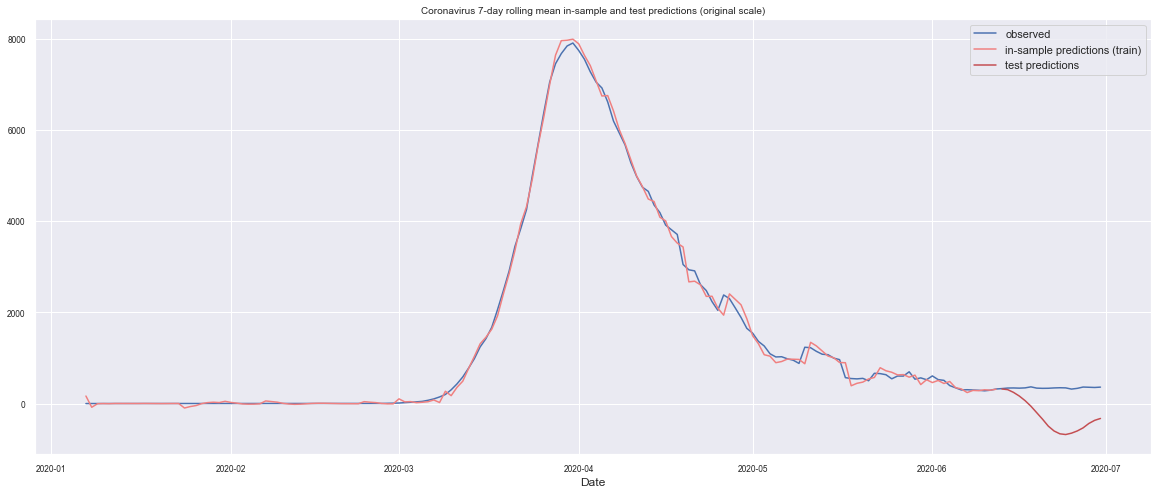

In [51]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [52]:
print("Test RMSE (original scale): %.3f" % np.sqrt(mean_squared_error(covid_ctry_varR[train_size:], testPredictS)))

Test RMSE (original scale): 703.740


# Save model so we can then update with future values

In [232]:
%pwd

'C:\\Users\\marta\\Documents\\MasterDataScience\\project\\KSchool-Master-Final-Project'

In [228]:
# Set model name
filename = './SpainSARIMAXmodel2.pkl'

# Pickle it
joblib.dump(results2, filename)

['./SpainSARIMAXmodel2.pkl']

In [229]:
# Load the model back in
loaded_model = joblib.load(filename)

# Update the model
#loaded_model.update(__dfnew___)

In [231]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  158
Model:               SARIMAX(0, 2, 4)   Log Likelihood                 449.560
Date:                Mon, 10 Aug 2020   AIC                           -863.120
Time:                        16:09:15   BIC                           -808.223
Sample:                    01-07-2020   HQIC                          -840.823
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain               -0.3242      0.644     -0.503      0.615      -1.586       0.938
workplaceclosing_Spain            -0.1915      0.188     -1.021      0.307      -0.559       0.176
cancelpublicevents_Spain           0.3402      0.269      1.263      0.207      -0.188       0.868
restrictionsongatherings_Spain    -0.0229      0.105     -0.217      0.828      -0.230       0.184
closepublictransport_Spain         0.0367      0.342      0.107      0.914      -0.633       0.706
stayathomerequirements_Spain       0.0185      0.301      0.061      0.951      -0.572       0.609
domestictravel_Spain               0.5245      0.627      0.836      0.403      -0.705       1.754
internationaltravel_Spain         -0.6046      0.368     -1.645      0.100      -1.325       0.116
publicinfocampaign_Spain           0.0196      0.357      0.055      0.956      -0.679       0.718
testingpolicy_Spain               -0.1736      0.042     -4.104      0.000      -0.257      -0.091
contacttracing_Spain              -0.0700      0.335     -0.209      0.835      -0.728       0.588
mask_Spain                         1.5355      0.411      3.732      0.000       0.729       2.342
FlightsArr_Spain                   0.0217      0.282      0.077      0.939      -0.532       0.575
ma.L1                             -0.6687      0.060    -11.138      0.000      -0.786      -0.551
ma.L2                             -0.0065      0.072     -0.090      0.929      -0.148       0.135
ma.L3                              0.2992      0.070      4.287      0.000       0.162       0.436
ma.L4                              0.0265      0.064      0.410      0.682      -0.100       0.153
sigma2                             0.0002   1.58e-05     11.574      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       50.02   Jarque-Bera (JB):                71.05
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):              29.87   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""